We study the log-returns of theforward contract for a years baseload power in Germany in 2021  using the variance gamma (VG) process in the model for log-price dynamics.
This project is based on the lecture that Matteo Gardini gave at the University of Helsinki in 26 February 2025. 


This project analyzes the log-returns of a forward contract for German baseload power for the 2021 calendar year (DEBY - **De**utschland **b**aseload **y**ear). We model the log-price dynamics using the variance gamma (VG) process.

The methodology is based on a lecture given by Matteo Gardini at the University of Helsinki in February 2025. *([Link](vg_energy_markets_helsinki.pdf) to slides.)*

## The variance gamma process
Assume that the log-returns of forward contract are driven by a Variance Gamma process:
$$d \log S(t) = \theta \, dg(t) + \sigma \, dW\left(g(t)\right),$$
where

- $t \geq 0$ is the time,

- $\theta \in \mathbb{R}$ is the drift parameter,

- $\sigma \in \mathbb{R}^+$ is the volatility parameter,

- $g = \{ g(t); t \geq 0 \}$ is a Gamma process, so

    - $\displaystyle g(t) \sim \Gamma\left( \tfrac{t}{\nu}, \nu \right)$ (the process increments are $\Gamma$-distributed)

- $\nu \in \mathbb{R}^+$ is the variance rate of the Gamma process

- $W$ is a standard Brownian motion independent of $g$ .

In this case the vector parameter we want to estimate is $\Theta = (\theta, \sigma, \nu)$ .

### 1. Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy import stats

import data_loading
import math_formulas

## Part I: Historical Calibration (Maximum Likelihood Estimation)
We fit the VG parameters to the time series of historical log-returns using maximum likelihood estimation (MLE). The optimization is based on the exact transition density of the VG process over a time interval $\Delta t$ [^1]:
$$f_{\Theta}(x_i) = \frac{\displaystyle 2\,\exp\left(\frac{\theta \cdot x}{\sigma^2}\right)}{\displaystyle\sigma\,\sqrt{2\,\pi}\,\nu^{\displaystyle\tfrac{\Delta t}{\nu}}\,\Gamma\left(\frac{1}{\nu}\right)}
\left( \frac{|x|}{\displaystyle\sqrt{\frac{2 \sigma^2}{\nu} + \theta^2}} \right)^{\displaystyle\tfrac{\Delta t}{\nu} - \tfrac12}
K_{\displaystyle\tfrac{\Delta t}{\nu} - \tfrac12} \left( \frac{\displaystyle|x| \sqrt{\frac{2 \, \sigma^2}{\nu} + \theta^2}}{\sigma^2} \right)$$where

- $\Gamma(x)$ is the Gamma function and

- $K_\eta(\cdot)$ is the modified Bessel function of the second kind.

We minimize the log likelihood fo the model. Working with the log-likelihood function is beneficial for, among other things, numerical stability, the likelihood function is generally a product of very small numbers.

[^1] This is given in *"A Stochastic Process Toolkit for Risk Management. Technical report"* by Brigo, Dalessandro, Neugebauer, and Triki (2007). [PDF](https://arxiv.org/pdf/0812.4210).

In [2]:
HIST_FILE = "Historical_Prices_FWD_Germany.csv"
REF_DATE = '2019-11-19'

try:
    log_returns = data_loading.get_historical_log_returns(
        hist_file=HIST_FILE,
        date_col='Date',
        price_col='DEBY2021',
        cutoff_date_str=REF_DATE
    )
    print(f"Loaded {len(log_returns)} historical log-returns successfully.")
except (ValueError, FileNotFoundError) as e:
    print(f"Error loading historical data: {e}")

Loaded 649 historical log-returns successfully.


To get a robust starting point for the calibration, we estimate initial values of the parameters using the generalized method of moments *(matching the model's theoretical moments to the empirical moments - mean, variance, skewness, kurtosis - of the data)*.

In [3]:
dt = 1/252

x0_h = math_formulas.get_initial_guess_moments(log_returns, dt)
print("Initial Guess (Method of Moments)")
print(f"theta0: {x0_h[0]:.4f}")
print(f"nu0: {x0_h[1]:.4f}")
print(f"sigma0: {x0_h[2]:.4f}")

Initial Guess (Method of Moments)
theta0: -0.1950
nu0: 0.0047
sigma0: 0.1923


In [4]:
bounds_h = ((-1, 1), (1e-6, 1), (1e-6, 1))

mle_result = minimize(
    math_formulas.neg_log_likelihood, 
    x0_h,
    args=(log_returns, dt), 
    bounds=bounds_h,
    method='L-BFGS-B'
)

theta_h, nu_h, sigma_h = mle_result.x

print("Calibrated Parameters (Historical MLE)")
print(f"Theta: {theta_h:.6f}")
print(f"Nu:    {nu_h:.6f}")
print(f"Sigma: {sigma_h:.6f}")

Calibrated Parameters (Historical MLE)
Theta: 0.184439
Nu:    0.002267
Sigma: 0.190679


/home/ambrus/Dokumentumok/UH/SMEM/geminifinal/math_formulas.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  v2 = (nu**a) * np.sqrt(2 * np.pi) * sigma * gamma_func(a)


### Visualization

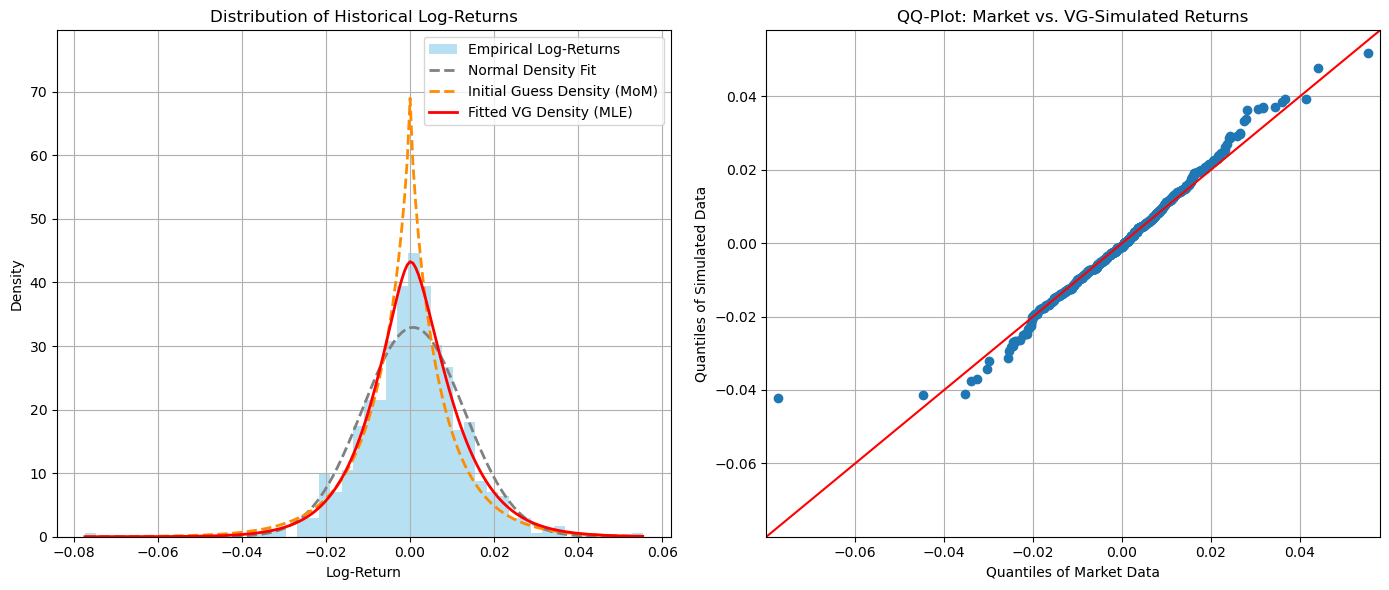

In [5]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(log_returns, bins=50, density=True, label='Empirical Log-Returns', alpha=0.6, color='skyblue')

x_grid = np.linspace(log_returns.min(), log_returns.max(), 200)

mu, std = stats.norm.fit(log_returns) 
pdf_normal = stats.norm.pdf(x_grid, mu, std)
plt.plot(x_grid, pdf_normal, '--', color='gray', lw=2, label='Normal Density Fit')

pdf_initial_guess = math_formulas.vg_density(x_grid, x0_h[0], x0_h[1], x0_h[2], dt)
plt.plot(x_grid, pdf_initial_guess, '--', color='darkorange', lw=2, label='Initial Guess Density (MoM)')

pdf_fitted = math_formulas.vg_density(x_grid, theta_h, nu_h, sigma_h, dt)
plt.plot(x_grid, pdf_fitted, 'r-', lw=2, label='Fitted VG Density (MLE)')

plt.title('Distribution of Historical Log-Returns')
plt.xlabel('Log-Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.ylim(top=plt.ylim()[1] * 1.1)

simulated_returns = math_formulas.vg_simulation(1, len(log_returns), dt, (theta_h, nu_h, sigma_h))

plt.subplot(1, 2, 2)
sm.qqplot_2samples(log_returns, simulated_returns, line='45', ax=plt.gca())
plt.title('QQ-Plot: Market vs. VG-Simulated Returns')
plt.xlabel('Quantiles of Market Data')
plt.ylabel('Quantiles of Simulated Data')
plt.grid(True)

plt.tight_layout()
plt.show()

The histogram of log-returns clearly exhibits a noticably higher peak and heavier tails compared to the normal distribution fitted to the same data. The VG density successfully captures these features, justifying its use over a simpler Gaussian model.

The Q-Q plot confirms this deviation from normality, as the empirical quantiles in the tails diverge significantly from the theoretical quantiles of a VG-simulated sample. This non-normality justifies the choice of the VG process.

## Part II: Risk-neutral calibration

To implement the *risk-neutral calibration* we will use a modified version of the Black-76 for future options pricing: we model the forward price dynamics using the above described VG process (instead of relying upon the lognormal dynamics in the common Black-76 model). So the value of the call is the discounted expected payoff under the risk-neutral measure $\mathbb{Q}$:
$$
C(K,T) =\exp(-rT)\mathbb{E}^{\mathbb{Q}}\big[(F_T-K)^+\big]
$$
and the forward log-price evolves under $\mathbb{Q}$ as:
$$\displaystyle\log F_T = \log F_0 + \omega T + X_T$$
where the martingale corection term $\displaystyle\omega = \tfrac{1}{\nu}\log\!\left(1 - \theta\nu - \tfrac12\sigma^2\nu\right)$, to ensure that the mean rate of return on the stock equals the interest rate $r$ (i.e. that $\mathbb{E}^{\mathbb{Q}}[F_T] = F_0$).

To efficiently evaluate the option prices we used the fast Fourier transform (FFT) to invert the modified call price according to Carr & Madan[^2]. The characteristic funtion of $\log(F_t)$ is
$$
\phi (u) = \exp\left(iu(\log F_0 + \omega T)\right)
\left( 1 - i\theta\nu u + \frac12\sigma^2\nu u^2 \right)^{\displaystyle\tfrac{-T}{\nu}}.
$$
We obtain the call prices using FFT as:
$$C(K,T) = \frac{\exp(-\alpha k)}{\pi} \operatorname{Re}\left[\int_0^\infty \exp(-ivk) \psi(v) dv\right]$$
where:

- $\displaystyle k = \log(\tfrac{K}{F_0})$ is the log-moneyness,
- $\displaystyle \psi(v) = \tfrac{\exp(-rT)\phi_{\log}(v-(\alpha+1)i)}{\alpha^2 + α - v^2 + i(2\alpha+1)v}$,
- $\phi(u)$ is our VG log-price characteristic function,
- $\alpha > 0$ is a dampening parameter.

The calibration procedure minimizes the sum of squared errors between the prices generated by the FFT and the observed market prices across all available maturities and strikes in the data.

[^2]: Carr, P. & Madan, D. B. (1999). “Option valuation using the Fast Fourier Transform.” *Journal of Computational Finance*, 2(4), 61–73. [PDF](https://engineering.nyu.edu/sites/default/files/2018-08/CarrMadan2_0.pdf)

In [6]:
FWD_FILE = "Forward_Prices.csv"
OPT_FILE = "Options_Prices_Calendar_2021.csv"
RISK_FREE_RATE = 0.01

TARGET_FWD_NAME = 'Phelix-DE Base Year Future'
TARGET_DELIVERY_PERIOD = '2021.01'
TARGET_OPTION_UNDERLYING = 'DEBY 2021.01'

In [7]:
try:
    F0 = data_loading.get_f0(FWD_FILE, name=TARGET_FWD_NAME, delivery_period=TARGET_DELIVERY_PERIOD)
    T, K, P = data_loading.get_option_data(OPT_FILE, underlying=TARGET_OPTION_UNDERLYING, ref_date_str=REF_DATE)
    
    print("Option Data Loaded Successfully")
    print(f"Forward Price (F0): {F0:.2f}")
    print(f"Number of options for calibration: {len(P)}")
    
except (ValueError, FileNotFoundError) as e:
    print(f"Error during data loading: {e}")

Option Data Loaded Successfully
Forward Price (F0): 46.60
Number of options for calibration: 313


In [8]:
x0_rn = np.array([theta_h, nu_h, sigma_h]) #we use these values for convenience
bounds_rn = ([-1.0, 1e-6, 1e-6], [1.0, 2.0, 2.0])

result_rn = least_squares(
    math_formulas.calibration_residuals, 
    x0_rn, 
    args=(F0, T, RISK_FREE_RATE, K, P), 
    bounds=bounds_rn,
    method='trf'
)

theta_rn, nu_rn, sigma_rn = result_rn.x

print("Calibrated Parameters (Risk-Neutral)")
print(f"Theta: {theta_rn:.6f}")
print(f"Nu:    {nu_rn:.6f}")
print(f"Sigma: {sigma_rn:.6f}")

Calibrated Parameters (Risk-Neutral)
Theta: 0.124150
Nu:    0.169399
Sigma: 0.219874


## Part III: Comparison of Results

Finally, we plot the market prices against the prices generated by both the historical and risk-neutral parameters.

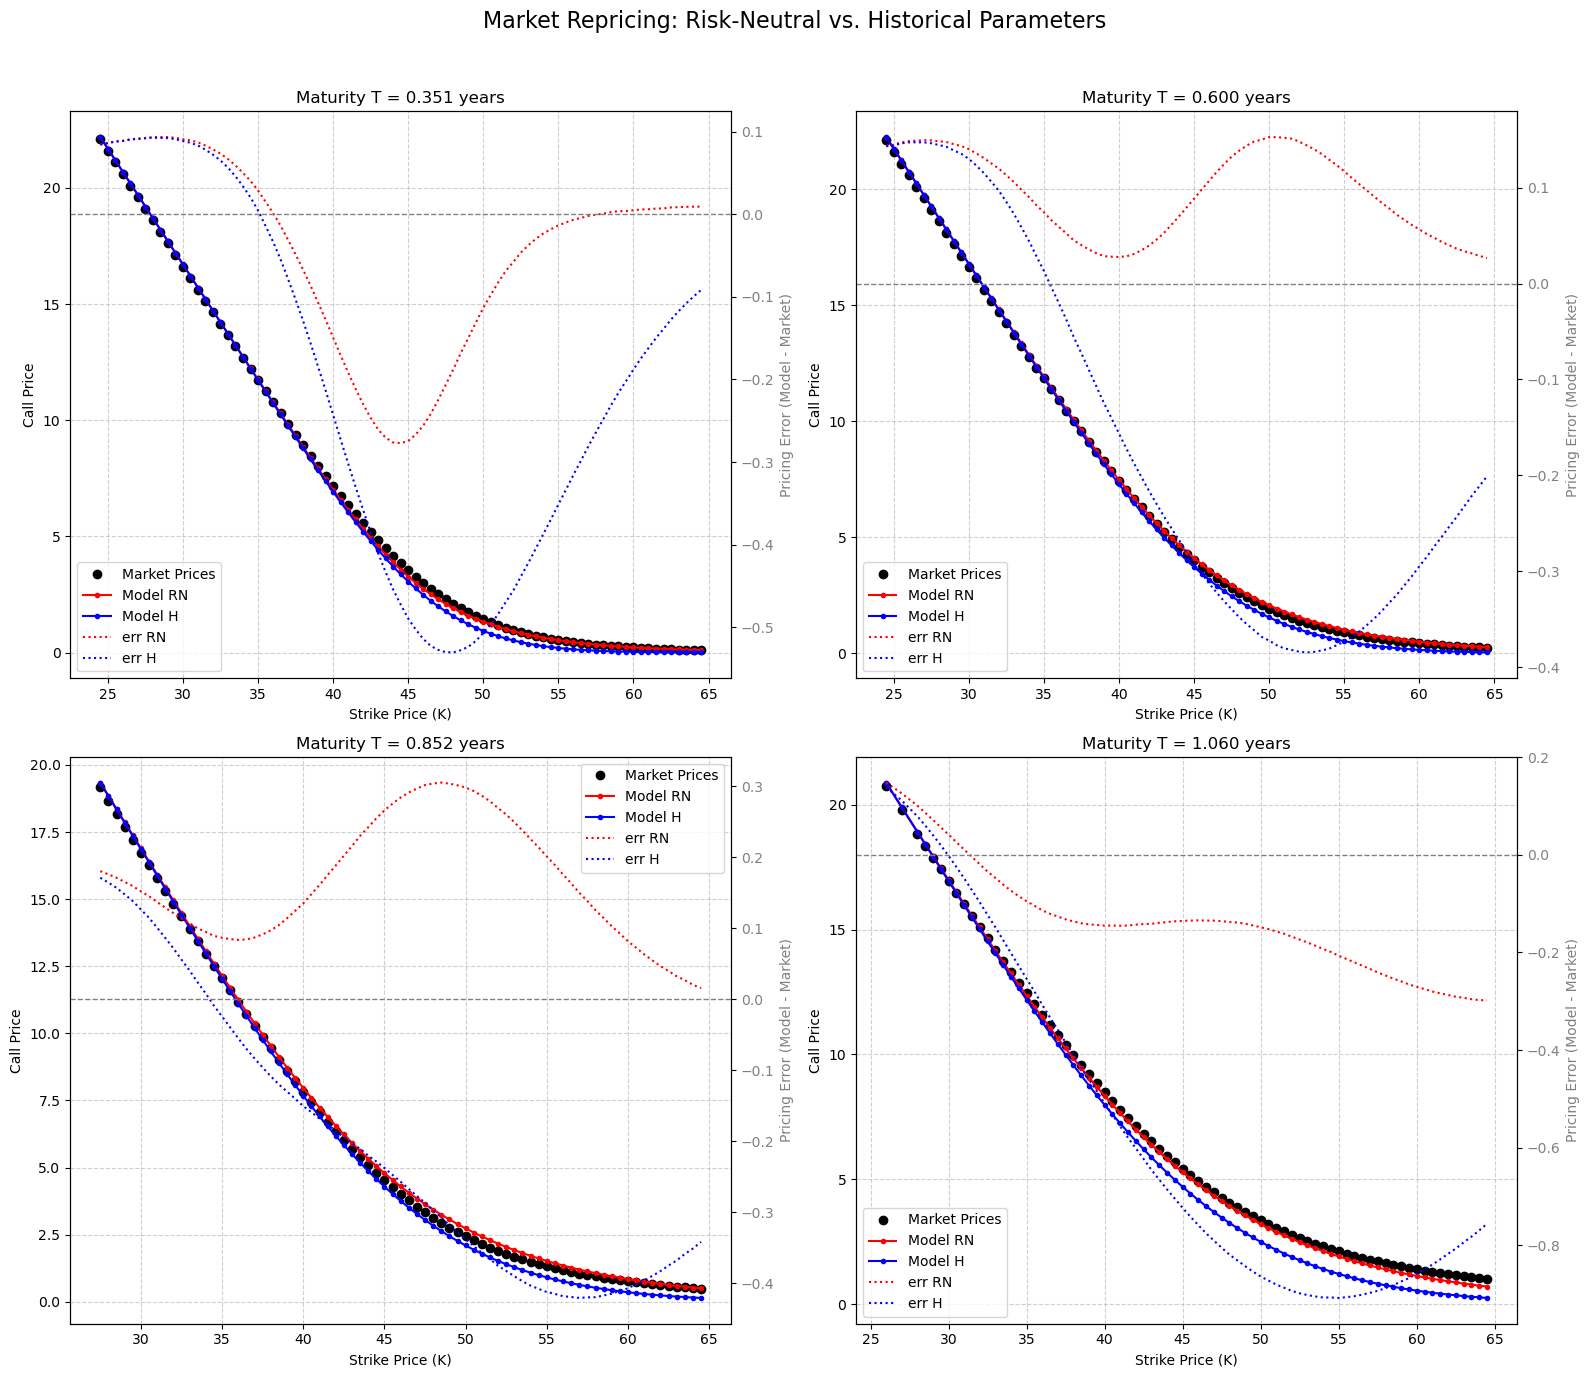

In [9]:
params_rn = {'theta': theta_rn, 'nu': nu_rn, 'sigma': sigma_rn}
params_h = {'theta': theta_h, 'nu': nu_h, 'sigma': sigma_h}

omega_rn = (1 / params_rn['nu']) * np.log(1 - params_rn['theta'] * params_rn['nu'] - (params_rn['sigma']**2 * params_rn['nu']) / 2)
omega_h = (1 / params_h['nu']) * np.log(1 - params_h['theta'] * params_h['nu'] - (params_h['sigma']**2 * params_h['nu']) / 2)

unique_maturities = np.unique(T)

n_maturities = len(unique_maturities)
n_cols = 2 if n_maturities > 1 else 1
n_rows = (n_maturities + 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 7 * n_rows), squeeze=False)
axes = axes.flatten()

fig.suptitle('Market Repricing: Risk-Neutral vs. Historical Parameters', fontsize=16)

for i, t in enumerate(unique_maturities):
    ax1 = axes[i]
    idx = (T == t)
    market_strikes = K[idx]
    market_prices = P[idx]

    cf_rn = lambda w: math_formulas.phi_vg(w, F0, RISK_FREE_RATE, omega_rn, t, params_rn['theta'], params_rn['nu'], params_rn['sigma'])
    prices_fft_rn, log_strikes_fft_rn = math_formulas.fft_pricing(t, RISK_FREE_RATE, cf_rn)
    model_prices_rn = interp1d(log_strikes_fft_rn, prices_fft_rn, kind='linear', fill_value="extrapolate")(np.log(market_strikes))
    
    cf_h = lambda w: math_formulas.phi_vg(w, F0, RISK_FREE_RATE, omega_h, t, params_h['theta'], params_h['nu'], params_h['sigma'])
    prices_fft_h, log_strikes_fft_h = math_formulas.fft_pricing(t, RISK_FREE_RATE, cf_h)
    model_prices_h = interp1d(log_strikes_fft_h, prices_fft_h, kind='linear', fill_value="extrapolate")(np.log(market_strikes))

    err_rn_vec = model_prices_rn - market_prices
    err_h_vec = model_prices_h - market_prices

    sort_order = np.argsort(market_strikes)

    ax1.plot(market_strikes[sort_order], market_prices[sort_order], 'o', c='black', label='Market Prices')
    ax1.plot(market_strikes[sort_order], model_prices_rn[sort_order], '.-', c='red', label='Model RN')
    ax1.plot(market_strikes[sort_order], model_prices_h[sort_order], '.-', c='blue', label='Model H')
    ax1.set_xlabel('Strike Price (K)')
    ax1.set_ylabel('Call Price', color='black')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_title(f'Maturity T = {t:.3f} years')

    ax2 = ax1.twinx()
    ax2.plot(market_strikes[sort_order], err_rn_vec[sort_order], ':', c='red', label='err RN')
    ax2.plot(market_strikes[sort_order], err_h_vec[sort_order], ':', c='blue', label='err H')
    ax2.set_ylabel('Pricing Error (Model - Market)', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

for i in range(n_maturities, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The prices from the risk-neutral calibrated parameters (represented by bold green crosses), seems to provide a good fit to the actual market prices of the options (red circles) across all strikes and maturities. In contrast, the historical parameters (bold black crosses) systematically and significantly underprice the options.

From this, we draw two primary conclusions:

- The VG model can successfully capture the implied volatility smile and skew present in the market, implying suitability to application for option pricing.

- The parameters calculated forom historical prices trhough MLE is not a valid method for option pricing.

## Appendix - functions

### `math_formulas.py` module

- `vg_density(x: np.ndarray, theta: float, nu: float, sigma: float, T: float) -> np.ndarray` PDF for the VG process.

- `neg_log_likelihood(params: Tuple[float, float, float], sample: np.ndarray, dt: float) -> float` Negative log-likelihood objective function for the VG process. Used by the optimizer for MLE.
  
- `vg_simulationvg_simulation(n_sim: int, n_dates: int, dt: float, params: Tuple[float, float, float]) -> np.ndarray` Simulates log-returns from a VG process.

- `get_initial_guess_moments(sample: np.ndarray, dt: float) -> tuple[float, float, float]` Calculates an initial guess for VG parameters using the method of moments. Returns a tuple containing the initial guess for theta, nu and sigma. Args:
    - `sample` a `np`-array of log-returns.
    - `dt` the time step

- `phi_vg(u, S0, r, omega, T, theta, nu, sigma)` Characteristic function of the VG describing the log-forward price under the risk-neutral measure $\mathbb{Q}$. This is the Fourier-domain representation of the price process required for `fft_pricing`. 

- `fft_pricing(T, r, char_func)` European call option pricing using the Carr-Madan FFT method.

- `calibration_residuals(params, S0, T, r, K, P)` Objective function for the market calibration of the VG model. This function is passed to the `least_squares` optimizer.

### `data_loading.py` module

- `get_historical_log_returns(hist_file, date_col, price_col, cutoff_date_str)` Loads historical forward prices from a CSV file, calculates the daily log-returns, and returns them as a pandas Series up to a specified cutoff date.

- `get_f0(fwd_file, name, delivery_period)` Loads the forward price data and extracts the initial forward price, `F0`​, for a specific contract on the valuation date.

- `get_option_data(opt_file, underlying, option_type, ref_date_str)` Loads the option data, filters for the specified underlying contract and option_type, and calculates the time to maturity `T` for each option. Returns the maturities `T`, strikes `K`, and market prices `P`.